## Corners, Local Feature Descriptors, Hough Transform (15pts)
<em>University of Virginia - Introduction to Computer Vision - Spring 2018 - Vicente Ordonez - vicente@virginia.edu</em><br/><br/>

### Nikhil Bhaip

In this lab we will apply our knowledge in the lectures on Interest Points, Local Feature Descriptors and the Hough Transform.

### 1. Corners as Interest Points (5pts).
In this section we will implement a version of the Harris Corner Detection. You are going to detect the corners in Rice Hall. Note that you are not allowed to use any outside library other than the ones explicitly indicated for this question. The idea is for you to implement the Harris corner detector and a variant of it.

In [1]:
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen

# Try maybe downloading the images in case the CS webserver goes down.
img_url = 'http://www.cs.virginia.edu/~vicente/vision/uvacs.jpg'
img = ndimage.imread(urlopen(img_url), mode = 'RGB')
print(img.shape)
# Plot the image.
def display_image(img):
  plt.figure()
  plt.gray()
  plt.imshow(img)
  plt.grid('off')
  plt.show()

display_image(img)


(528, 940, 3)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


**1.1 ** Compute and display $I_x^2$, $I_y^2$, and $I_xI_y$ using Sobel operators. You are only allowed to use scipy.signal.convolve2d for any convolutional operations. Feel free to reuse your code from the previous assignment. (1pts)

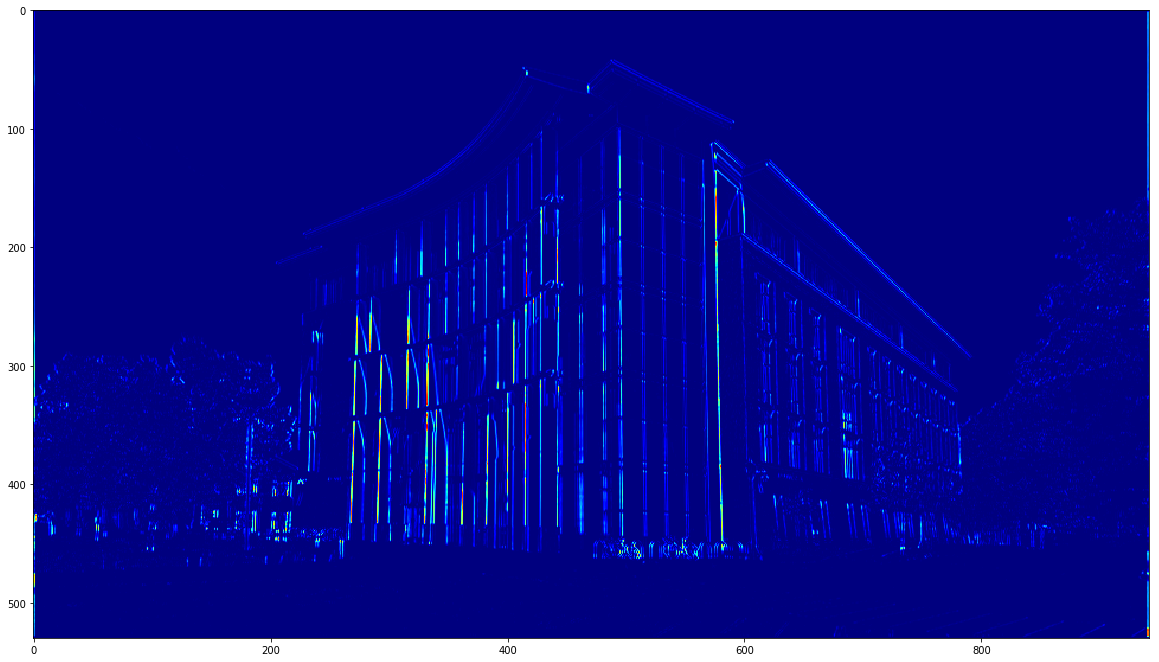

In [9]:
from scipy import signal
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20,20)

# Converting image to grayscale.
img_flt = img.astype('float')/255
img_gray = (img_flt[:, :, 0] + img_flt[:, :, 1] + img_flt[:, :, 2]) / 3.0

# Compute Ixx, Iyy and Ixy here.
sobel_x = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
Ix = signal.convolve2d(img_gray, sobel_x)
# note sobel_y is the transpose of sobel_x
sobel_y =  sobel_x.T 

Iy = signal.convolve2d(img_gray, sobel_y)

Ixx = Ix * Ix
Ixy = Ix * Iy
Iyy = Iy * Iy

# Plot Ixx, Iyy, Ixy.
plt.imshow(Ixx, cmap='jet')
# plt.figure(figsize=(20,4))
# plt.imshow(np.concatenate((Ixx, Iyy, np.abs(Ixy)), axis = 1), 
#            cmap =  'jet')
# plt.colorbar()
# plt.grid('off')
# plt.show()

**1.2** Show side by side the input image with the response map R computed using the original Harris detector with $\alpha=0.05$, and using the Harmonic mean formula proposed by Szeliski. Use a window/patch size of 12x12 to define the momentum matrix M. (2pts).

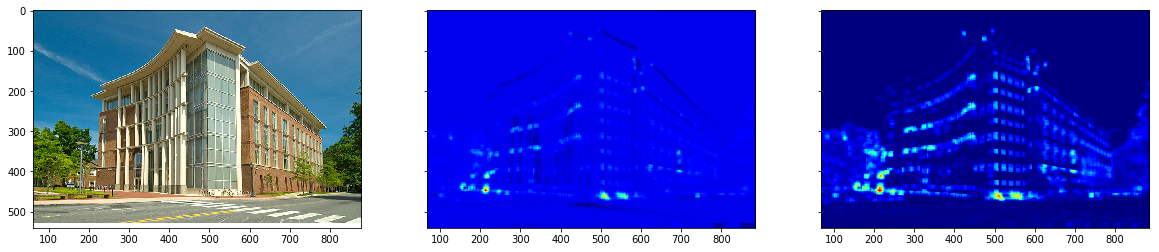

In [3]:
# please wait around 20-30 seconds for img processing

def calc_r_pix(moment_mat, alpha=0.05):
    det_m = np.linalg.det(moment_mat)
    trace_m = np.trace(moment_mat)
    return det_m - (alpha *(trace_m**2)), det_m / (trace_m*1.0)


# Compute the Rmap and RHarmonicMap map responses.
alpha = 0.05
size = 12
Ixx_kern = signal.convolve2d(Ixx, np.ones((size, size)))#, boundary="symm")
Ixy_kern = signal.convolve2d(Ixy, np.ones((size, size)))#, boundary="symm")
Iyy_kern = signal.convolve2d(Iyy, np.ones((size, size)))#, boundary="symm")

rows = Ixx_kern.shape[0]
cols = Ixx_kern.shape[1]
M = np.zeros((rows, cols, 2, 2))
RMap = np.zeros((rows, cols))
RHarmonicMap = np.zeros((rows, cols))

for x in range(Ixx_kern.shape[0]):
    for y in range(Ixx_kern.shape[1]):
        M[x][y][0][0] = Ixx_kern[x][y]
        M[x][y][1][1] = Iyy_kern[x][y]
        M[x][y][0][1] = M[x][y][1][0] = Ixy_kern[x][y]
        RMap[x][y], RHarmonicMap[x][y] = calc_r_pix(M[x][y], alpha)

# Plot Harris response outputs.
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize=(20, 4))
ax1.imshow(img);ax1.grid('off')
ax2.imshow(RMap, cmap = 'jet'); ax2.grid('off')
ax3.imshow(RHarmonicMap, cmap ='jet'); ax3.grid('off');

**1.3** Perform non-max supression on the outputs obtained in the previous step so that you get a list of pixels corresponding to corners for each method. Feel free to use any  method you can think of but the general idea is to leave only one point per corner and no two points with high values should be together. An easy way is to just define a minimum distance between corners of 5 pixels. The only pixels surviving (non-zero) after non-max should be the ones that a) pass a threshold (which you are free to define), and b) are the maximum pixel within their neighborhood. I am including outputs as an example of what it should more or less look like at the end. (2pts).

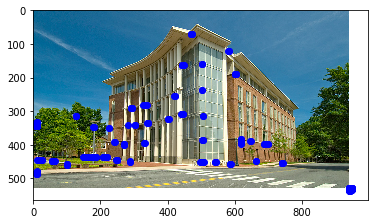

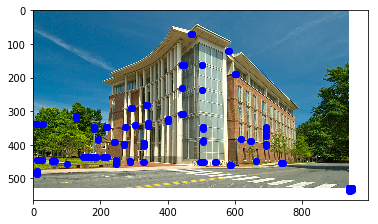

In [4]:
# Calculate pair-wise distances
# https://docs.scipy.org/doc/scipy/reference/spatial.distance.html


def nonmax(array):
    # Non-max supression and thresholding function.
    thresh = np.percentile(array, 99)
    array[array<thresh] = 0
    min_dist=25
    
    for j in range(min_dist, array.shape[0]-min_dist):
        for i in range(min_dist, array.shape[1]-min_dist):
            if array[j][i]!=0:
                array[j-min_dist-1:j,i-min_dist-1:i]=0
                array[j-min_dist-1:j,i+1:i+min_dist]=0
                array[j+1:j+min_dist,i+1:i+min_dist]=0
                array[j+1:j+min_dist,i-min_dist-1:i]=0
          
    return array

# np.nonzero extracts 2d coordinates of non-zero elements.
ys1, xs1 = np.nonzero(nonmax(RMap))
ys2, xs2 = np.nonzero(nonmax(RHarmonicMap))

# print(RMap.shape)
# print(points1[:5])
# dists = rm_nearby(points1)
# ys1, xs1 = points1[1], points1[0]
# print(dists.shape)
# print(points1)

# Method 1: Harris operator original score.
# Show image with corner coordinates marked with blue dots.
fig, ax = plt.subplots()
ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
ax.plot(xs1, ys1, '.b', markersize=12)
ax.grid('off')

# # Method 2: Szeliski's Harmonic mean.
# # Show image with corner coordinates marked with blue dots.
fig, ax = plt.subplots()
ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
ax.plot(xs2, ys2, '.b', markersize=12)
ax.grid('off')

**Final Comments:** What happens if you rotate the image? Will it still detect the same corners? What happens if you resize the image? Will it detect the same corners? When will you get more corners detected, if you resize up or resize down the image?

### 2. Image Retrieval by Matching Local Feature Descriptors (5pts).

In this section we will compute interest points using OpenCV's implementation of the DoG extrema operator, which unlike the Harris operator produces points that are also scale invariant, and then we will also use OpenCV's implementation of the SIFT feature descriptor. The task will be then to aggreate these features across the image to perform retrieval, and build a simple search/retrieval application.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


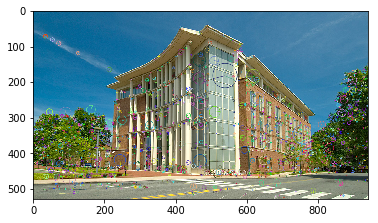

In [5]:
import cv2  # After running the above cell this should work.
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen

# Try maybe downloading the images in case the CS webserver goes down.
img_url = 'http://www.cs.virginia.edu/~vicente/vision/uvacs.jpg'
img = sp.misc.imread(urlopen(img_url), mode = 'RGB')

# Convert to grayscale using OpenCV's function.
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Create the SIFT interest point and feature descriptor extractor object.
sift = cv2.xfeatures2d.SIFT_create()

# Detect the interest points (keypoints).
keypoints = sift.detect(gray, None)
out =  cv2.drawKeypoints(img, keypoints, img, 
        flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure()
plt.imshow(out); plt.grid('off')
plt.show()


**2.1** Show the output of the SIFT descriptor the Rice Hall image at three different resolutions (0.7 image size, 0.5 image size, and 0.25 image size). Feel free to use cv2.resize. This is to make sure you have everything installed. (1pts)

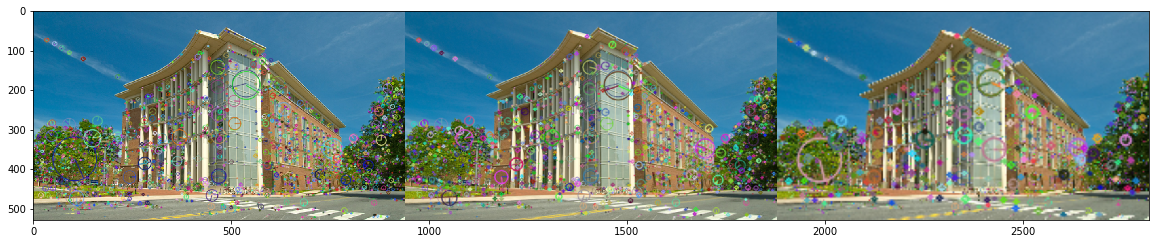

In [6]:
h, w, _ = img.shape

# Compute keypoint images for the three resized versions here.
# Display

img1 = cv2.resize(img, (int(0.7*w),int(0.7*h)))
img2 = cv2.resize(img, (int(0.5*w),int(0.5*h)))
img3 = cv2.resize(img, (int(0.25*w),int(0.25*h)))

gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
keypoints1 = sift.detect(gray1, None)
out1 =  cv2.drawKeypoints(img1, keypoints1, img1, 
        flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
keypoints2 = sift.detect(gray2, None)
out2 =  cv2.drawKeypoints(img2, keypoints2, img2, 
        flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

gray3 = cv2.cvtColor(img3, cv2.COLOR_RGB2GRAY)
keypoints3 = sift.detect(gray3, None)
out3 =  cv2.drawKeypoints(img3, keypoints3, img3, 
        flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

out1 = cv2.resize(out1, (w,h))
out2 = cv2.resize(out2, (w,h))
out3 = cv2.resize(out3, (w,h))

plt.figure(figsize=(20, 20))
plt.imshow(np.concatenate((out1, out2, out3), axis=1)); plt.grid('off')
plt.show()

**Final Comments:** Actually it is not very suprising that the keypoints are similar in all three images above because the DoG extrema operator is run at several resolutions and the maxima is taken across resolutions.

**2.2** In this section we will use two images of Rice Hall and try to match as many corresponding keypoints. For this task we will use **cv.detectAndCompute()**, which will compute the keypoints but also a 128-dimensional vector representing the SIFT feature descriptor for each keypoint. First, compute a matrix containing the distances between each pair of SIFT descriptors (s1, s2) where s1 is a descriptor for a keypoing in uvacs.jpg and s2 is a SIFT descriptor for a keypoing in uvacs2.jpg. Feel free to use any distance function that you want (2pts).



In [7]:
from scipy.spatial import distance_matrix

# Try maybe downloading the images in case the CS webserver goes down.
img_url1 = 'http://www.cs.virginia.edu/~vicente/vision/uvacs.jpg'
img_url2 = 'http://www.cs.virginia.edu/~vicente/vision/uvacs2.jpg'

# Read images.
img1 = ndimage.imread(urlopen(img_url1), mode = 'RGB')
img2 = ndimage.imread(urlopen(img_url2), mode = 'RGB')

sift = cv2.xfeatures2d.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# print(des1.shape)
# print(des2.shape)
# Create a distance matrix using distance (L1 norm)
dists_mat = distance_matrix(des1, des2, 1)
# print(dists_mat.shape)

kp1 = [kp.pt for kp in kp1]
kp2 = [kp.pt for kp in kp2]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  if __name__ == '__main__':


**2.3** Find the 80 closest pairs (s1, s2) and their corresponding keypoint locations on each image. Then plot their corresponding matches as in the picture provided below. Notice you might need to resize the second image to match the dimensions of the first image to put them side by side. Feel free to use OpenCVs cv2.resize function but not any of the matching or plotting functions included in OpenCV. Also, note that the points that you will obtain might be slightly different than the ones shown in the example, as these were obtained using an L1-distance (2pts).

(528, 940, 3)
(500, 774, 3)


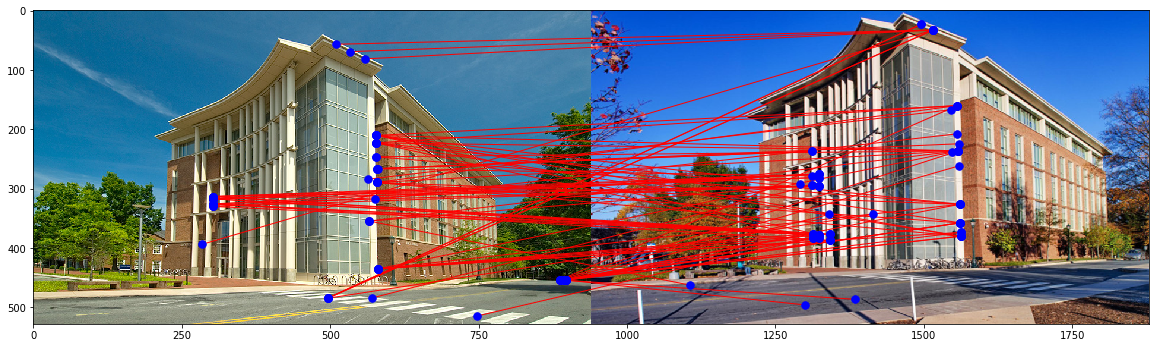

In [78]:
# https://stackoverflow.com/questions/16131208/a-function-for-returning-a-list-of-tuples-that-correspond-to-indices-of-all-elem
h, w, _ = img1.shape

# 1. Extract the indices with the 80 smallest distances.

closest_pairs = np.argsort(dists_mat, axis=None)[:80]
# print(closest_pairs)

# Take flat array and get 2D tuple coordinates of indices
kp_1_indices, kp_2_indices  = np.unravel_index(closest_pairs, dists_mat.shape)
# print(closest_pairs_tuples)

# 2. Find the keypoints corresponding to those distances in both images.
pts1 = (np.array(kp1)[kp_1_indices])
pts2 = (np.array(kp2)[kp_2_indices])

# Plot the images and a line between corresponding points.
# 1. Resize img2 to img1 size.
img2_resized = cv2.resize(img2, (w, h))

print(img1.shape)
print(img2.shape)
# 2. Project img2 pts to img1 coordinates based on image coordinates
pts2[:,0] += 1.11*w
pts2[:,1] += 0.01*h

fig, ax = plt.subplots(figsize=(20,40))
# # # Plot imges where out is 
out = np.concatenate((img1, img2_resized), axis=1)
ax.imshow(out, interpolation='nearest', cmap=plt.cm.gray)
for i in range(pts1.shape[0]): # Plot lines between matching pts.
    ax.plot([pts1[i, 0], pts2[i, 0]], 
        [pts1[i, 1], pts2[i, 1]], 'r-', linewidth=1)
ax.plot(pts1[:, 0], pts1[:, 1], '.b', markersize=15)  # Plot pts img1.
ax.plot(pts2[:, 0], pts2[:, 1], '.b', markersize=15)  # Plot pts img2.
ax.grid('off')


**Final Comments:** Robust matching algorithms will provide one-to-one mappings, unlike the output provided with this assignment. How could you implement that? Also, the naive implementation of the distance computations will be extremely slow, how would you accelerate the computation of these matches? Can you think of how geometry constraints and consistency could be used to obtain better matches? How could this type of matching be useful in an application?

### 3. Hough Transform for line detection (5pts).
In this section we will perform line detection by implementing the Hough Transform.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


Image size:  (528, 940, 3)


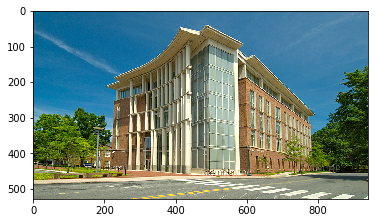

In [9]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen

# Try maybe downloading the images in case the CS webserver goes down.
img_url = 'http://www.cs.virginia.edu/~vicente/vision/uvacs.jpg'
img = sp.misc.imread(urlopen(img_url), mode = 'RGB')
img = img.astype('float') / 255

# Show the image size.
print('Image size: ', img.shape)

# Plot the image.
def display_image(img):
  plt.figure()
  plt.imshow(img)
  plt.grid('off')
  plt.show()
  
display_image(img)

**3.1** Use the Hough Transform to find all the lines in the image. Show the Hough Transform for the Rice Hall image (2pts).

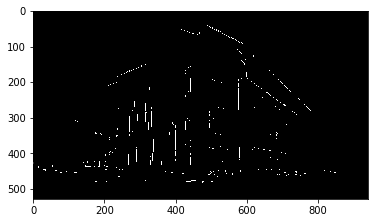

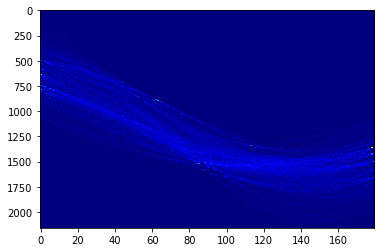

In [95]:
# Converting image to grayscale.
img_flt = img.astype('float')/255
img_gray = (img_flt[:, :, 0] + img_flt[:, :, 1] + img_flt[:, :, 2]) / 3.0

# Calculate sobel
sobel_x = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
sobel_y =  sobel_x.T 

grad_x = signal.convolve2d(img_gray, sobel_x, mode="same")
grad_y = signal.convolve2d(img_gray, sobel_y, mode="same")
mag_sobel = np.hypot(grad_x, grad_y)*255
# print(mag_sobel)

# non max suppression on sobel
edge_thresh= np.percentile(mag_sobel, 99)

mag_sobel[mag_sobel>edge_thresh] = 1
mag_sobel[mag_sobel!=1]=0

display_image(mag_sobel)

# # Get edge points 
edge_pts_x, edge_pts_y  = np.nonzero(mag_sobel)
edge_pts = np.column_stack((edge_pts_x, edge_pts_y))
# print(edge_pts)

h, w = img_gray.shape
max_degrees = 180
max_rho = int((h**2 + w**2)**0.5)
H_accum_mat = np.zeros((int(2*max_rho),max_degrees))
# print(H_accum_mat.shape)
for edge_pt in edge_pts:
    for theta in range(-90,90):
        pt_x = edge_pt[0]
        pt_y = edge_pt[1]
        theta_rad = theta*np.pi/180
        rho = int(pt_x* np.cos(theta_rad) + pt_y*np.sin(theta_rad))
        H_accum_mat[rho+max_rho][theta+90]+=1

plt.imshow(H_accum_mat,aspect='auto',cmap='jet')
plt.show()


**3.2** Find the peaks in the Hough Transform computed in the previous step and plot the original images with red lines overlaid showing the detected lines (3pts).

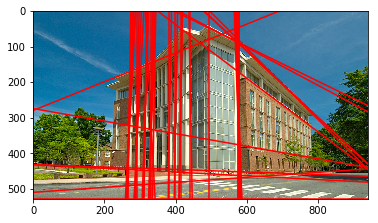

In [96]:
# Your code goes here. no sample output provided.
def nonmax(array):
    # Non-max supression and thresholding function.
    thresh = np.percentile(array, 99.985)
#     thresh = np.max(array)
#     print(thresh)
    array[array<thresh] = 0
    min_dist=15
#     print(thresh)
    for j in range(min_dist, array.shape[0]-min_dist):
        for i in range(min_dist, array.shape[1]-min_dist):
            if array[j][i]!=0:
                array[j-min_dist-1:j,i-min_dist-1:i]=0
                array[j-min_dist-1:j,i+1:i+min_dist]=0
                array[j+1:j+min_dist,i+1:i+min_dist]=0
                array[j+1:j+min_dist,i-min_dist-1:i]=0
          
    return array
# plt.hist(H_accum_mat.ravel(),256,[0,256]); 
# plt.show()
# print(H_accum_mat)
# polar_coord = np.max(H_accum_mat )
rho, theta = np.nonzero(nonmax(H_accum_mat))

polar_coord = np.column_stack((rho, theta))

# plt.imshow(img,aspect='auto')
domain = np.arange(img.shape[1])
for polar_pt in polar_coord:
    rho_i = polar_pt[0]-max_rho
    theta_i = (polar_pt[1]-90)*np.pi/180
    sin_theta_i = np.sin(theta_i)+0.000000000000001
    
    slope = -1*np.cos(theta_i)/sin_theta_i
    intercept = rho_i /sin_theta_i
    
    output = slope*domain+intercept
    
    plt.plot(output,domain, color='r')
plt.imshow(img, aspect='equal')

plt.show()


**Final Comments:** The Hough Transform detects lines, how would you modify the algorithm to find instead line segments? 